<a href="https://colab.research.google.com/github/dipayandas97/Indoor-Navigation-System/blob/master/(2)_SNN_Genetic_Algorithm_RateCoded_input.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from google.colab import drive
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split

drive.mount('/content/drive/')
import sys
sys.path.append('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/')

from SNN_localization_preprocessing import transform_data
from neuron_models import LIF
from GA import GA

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


#Data preparation

In [0]:
class rate_encode:
    def __init__(self, time_window, input_range, output_range):
        self.time_window = time_window
        self.min_input = input_range[0]
        self.max_input = input_range[1]
        self.min_output = output_range[0]
        self.max_output = output_range[1]

    def encode(self, vector): #1D vector
        spike_train = []
        for v in vector:
            freq = (((v-self.min_input)/(self.max_input-self.min_input)) * (self.max_output-self.min_output)) + self.min_output 
            t = (1 / freq) * 1000 #ms                    
            spikes = np.zeros(self.time_window)
            k=0
            while k<self.time_window:
                spikes[k] = 1
                k += int(t)
            spike_train.append(spikes)
        spike_train = np.asarray(spike_train)
        return spike_train   

In [0]:
#functions to transform scaler data to spike time points and vice versa
#[a,b] : Min,Max value of temporal encoding
#[M:m] : Max,Min value that variable f can take

def scaler_to_temporal_value(f):
    #return (((b-a)/(M-m))*f) + (((a*M)-(b*m))/(M-m))
    return 33+(3*f) #since input range[0,22] so output range will be [0,66]. additional 33 settling time can be allotted in the beginning
    
def temporal_to_scaler_value(y):
    #return (y - (((a*M)-(b*m))/(M-m))) / ((b-a)/(M-m))
    return (y-33)/3

In [68]:
#Data--------------------------------------------------------------------------------------------------------------------------------------------------
#signal #Input signal : shape(batchsize, features, timesteps)
f = open('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/total_data.pkl', 'rb')
X, Y = pickle.load(f)
f.close()

#Rate Encode X
encoder = rate_encode(100, (-110,-22), (10, 200))
signal_X = []
for x in X:
    signal_X.append(encoder.encode(x))
signal_X = np.asarray(signal_X)

#Time Encode Y
signal_Y = []
min_y, max_y = np.min(Y), np.max(Y)
for y in Y:
    t = scaler_to_temporal_value(f=y)
    spikes_y = np.zeros((2,100))
    spikes_y[0][t[0]], spikes_y[1][t[1]] = 1,1
    signal_Y.append(spikes_y)
signal_Y = np.asarray(signal_Y)

X_train, X_test, y_train, y_test = train_test_split(signal_X, signal_Y, test_size=0.2, shuffle=True)
print('Train sizes: ',X_train.shape, y_train.shape)
print('Test sizes: ',X_test.shape, y_test.shape)



Train sizes:  (4080, 4, 100) (4080, 2, 100)
Test sizes:  (1020, 4, 100) (1020, 2, 100)


#Fitness Calculation

##error()

In [0]:
#Spike distance----------------------------------------------------------------------------------------------------------------------------------------

def error(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise Exception('Shape of y_true and y_pred is not equal')
    
    true_timestamps, pred_timestamps = np.zeros((y_true.shape[0],))-1, np.zeros((y_pred.shape[0],))-1
    
    for d in range(y_true.shape[0]):
    
        for t in range(y_true.shape[1]):
            if y_true[d][t] == 1:           # |delta(n)| = 1
                true_timestamps[d] = t
                break
        for t in range(y_pred.shape[1]):
            if y_pred[d][t] == 5:           # |V_spike| = 5
                pred_timestamps[d] = t
                break                        
        #if no spikes have been predicted
        if pred_timestamps[d] == -1:
            pred_timestamps[d] = y_true.shape[1] - true_timestamps[d]

    pred_timestamps[pred_timestamps==-1] = 0
    true_timestamps[true_timestamps==-1] = 0
    e = [(true_timestamps[i]-pred_timestamps[i])**2 for i in range(y_true.shape[0])]
    e = np.sqrt(np.sum(e))
    return e

##mp_fitness()

In [0]:
#Multi-proecssing

def mp_fitness(synapse_vector, output): #fitness of one vectored synapse
    
    #Network instance for this sub-process-----------------------------------------------------------------------------------------------------------------------------------------------
    dt = 0.125 #ms
    m, n = 4, 2 
    h_layer = []
    for i in range(n):
        neuron = LIF(threshold=0.1, dt=dt, Cm=2)
        h_layer.append(neuron)    
    #--------------------------------------------------------------------------------------------------------------------------------------------
    
    synapse_id = synapse_vector[-1] 
    synapse_vector = synapse_vector[:-1]
    synapse_vector = synapse_vector.reshape(1, synapse_vector.shape[0])
    synapse = ga.vector_to_matrix(vectors = synapse_vector, matrices_dim=synapse_dim)[0][0]

    #Error on train_data
    temp_train_score = []      
    for i in range(X_train.shape[0]):     
        signal = X_train[i] #Input
        activations=[]      #Output
    
        for l in range(n):
            activations.append([])
            h_layer[l].initialize()
        
        simulation_time = 100
        for t in range(simulation_time):            
            for idx,neuron in enumerate(h_layer):
                input_I = np.dot(synapse[idx], signal[:,t])
                activations[idx].append(neuron.update(input_I, t))
        activations = np.asarray(activations)
        
        temp_train_score.append( error(y_train[i],activations) )

    #Error on test data
    temp_test_score = []        
    for i in range(X_test.shape[0]):     
        signal = X_test[i] #Input
        activations=[]     #Output
    
        for l in range(n):
            activations.append([])
            h_layer[l].initialize()

        for t in range(simulation_time):            
            for idx,neuron in enumerate(h_layer):
                input_I = np.dot(synapse[idx], signal[:,t])
                activations[idx].append(neuron.update(input_I, t))
        activations = np.asarray(activations)
        
        temp_test_score.append( error(y_test[i],activations) )

    output.put([synapse_id, np.mean(temp_train_score), np.mean(temp_test_score)])

#Main : Optimization

##Using multi-processing

In [0]:
import time
def dum(a, t, output):
    time.sleep(t)
    print(t)
    output.put(a)

In [0]:
import multiprocessing as mp
output = mp.Queue()

pop = np.arange(10)
t = np.concatenate([np.arange(10,5,-1), np.arange(6,10,1)])

processes=[]
for ix,syn in enumerate(pop):
    p = mp.Process(target = dum, args=(syn, t[ix-1], output))
    processes.append(p)

for p in processes:
    p.start()

for p in processes:
    p.join()

results = [output.get() for p in processes]

print(results)

6
6
7
7
8
8
9
9
9
10
[5, 6, 4, 7, 3, 8, 0, 2, 9, 1]


In [0]:
t

array([9, 8, 7, 6, 6, 7, 8, 9])

In [0]:
import multiprocessing as mp
output = mp.Queue()

pop = np.random.uniform(-1.,2.,size=(2, 1, n, m))

processes=[]
for syn in pop:
    p = mp.Process(target = mp_fitness, args=(syn, output))
    processes.append(p)

for p in processes:
    p.start()

for p in processes:
    p.join()

results = [output.get() for p in processes]

print(results)

Training chromosome:  [[[ 0.44329736  1.04577818  1.11899767  0.64994026]
  [ 1.13565153 -0.60587481  0.7830648  -0.00432822]]]
Training chromosome:  [[[ 0.80797252  1.52172621  0.36678232  1.6529984 ]
  [ 0.86253905 -0.43839262  1.89781122  1.92233191]]]
Testing chromosome:  [[[ 0.80797252  1.52172621  0.36678232  1.6529984 ]
  [ 0.86253905 -0.43839262  1.89781122  1.92233191]]]
Testing chromosome:  [[[ 0.44329736  1.04577818  1.11899767  0.64994026]
  [ 1.13565153 -0.60587481  0.7830648  -0.00432822]]]
[[307.4229740256599, 306.98612810550134], [161.95301944194773, 162.64077106885355]]


##sequential GA

In [0]:
#Genetic algorithm parameters:------------------------------------------------------------------------------------------------------------------------
#    Mating Pool Size (Number of Parents)
#    Population Size
#    Number of Generations
#    Mutation Percent

sol_per_pop = 200
num_parents_mating = 50
num_generations = 500
mutation_percent = 30
ga = GA()

#initial population :         
initial_population_weights = np.random.uniform(-1.,2.,size=(sol_per_pop, 1, n, m))
population_matrices = initial_population_weights
population_vectors = ga.matrix_to_vector(initial_population_weights)

train_error, test_error = [], []

for generation in range(num_generations):
    print('============================================================================')
    print("Generation : ", generation+1,'/',num_generations)
    print('============================================================================')    
    
    #Calculate fitness for each population_vector in population    
    fitness_train, fitness_test = fitness(population_vectors)
    
    train_error.append(np.min(fitness_train))
    test_error.append(np.min(fitness_test))
    print('Train Error:', train_error[-1])
    print('Test Error:', test_error[-1])
    
    #Select best parents 
    parents = ga.select_mating_pool(population=population_vectors, fitness=fitness_train.copy(), mode='min', num_parents=num_parents_mating)
    print(parents.shape[0],'New parents generated...')
    
    #Crossover parents
    offsprings = ga.crossover(parents=parents, num_offsprings=sol_per_pop-num_parents_mating)
    print(offsprings.shape[0],'New offsprings produced...')
    
    #Mutate offsprings
    mutated_offsprings = ga.mutate(offsprings, mutation_percent=mutation_percent)
    print(mutated_offsprings.shape[0],'offsprings mutated')
    
    #Create new population
    population_vectors[:parents.shape[0],:] = parents
    population_vectors[parents.shape[0]:,:] = mutated_offsprings
    print('New population created')
    
    #Update the result of this generation in report files
    f = open('train_error.pkl','wb')
    pickle.dump(train_error, f)
    f.close()
    f = open('test_error.pkl','wb')
    pickle.dump(test_error, f)
    f.close()
    f = open('best_paramater_found.pkl','wb')
    pickle.dump(parents[0], f)
    f.close()

    plt.plot(train_error)
    plt.plot(test_error)
    plt.show()

##Parallel GA

Generation :  1 / 100
Train Error: 59.7943064166317
Test Error: 60.896777101092646
100 New parents generated...
200 New offsprings produced...
200 offsprings mutated
New population created


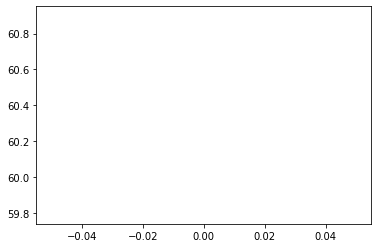

Generation :  2 / 100
Train Error: 49.775994419885734
Test Error: 50.844600672764535
100 New parents generated...
200 New offsprings produced...
200 offsprings mutated
New population created


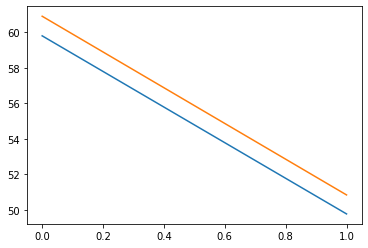

Generation :  3 / 100
Train Error: 47.37139413908742
Test Error: 48.40572258526492
100 New parents generated...
200 New offsprings produced...
200 offsprings mutated
New population created


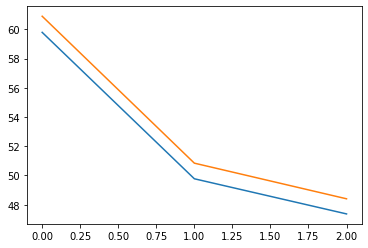

Generation :  4 / 100


In [0]:
import multiprocessing as mp
output = mp.Queue()

#Genetic algorithm parameters:------------------------------------------------------------------------------------------------------------------------
#    Mating Pool Size (Number of Parents)
#    Population Size
#    Number of Generations
#    Mutation Percent

sol_per_pop = 300
num_parents_mating = 100
num_generations = 100
mutation_percent = 30
ga = GA()

#initial population :         
synapse_dim = (1,1,2,4)
initial_population_weights = np.random.uniform(-0.5, 1.,size=(sol_per_pop, 1, 2, 4))
population_vectors = ga.matrix_to_vector(initial_population_weights)

train_error, test_error = [], []

for generation in range(num_generations):
    print('============================================================================')
    print("Generation : ", generation+1,'/',num_generations)
    print('============================================================================')    
    
    #Calculate fitness for each population_vector in population    
    #send population vector for each process with id at -1 position

    temp_population_vectors = np.hstack((population_vectors, np.arange(population_vectors.shape[0]).reshape(population_vectors.shape[0],1)))
    
    processes=[]
    for syn in temp_population_vectors:
        p = mp.Process(target = mp_fitness, args=(syn, output))
        processes.append(p)
    for p in processes:
        p.start()
    for p in processes:
        p.join()
    results = [output.get() for p in processes]
    results = np.asarray(results)
    results = results[np.argsort(results[:,0])]     #Arrange according to id 
    results = results[:, 1:]                        #remove ids from first column
    
    fitness_train, fitness_test = [], []
    for r in results:
        fitness_train.append(r[0])
        fitness_test.append(r[1])

    train_error.append(np.mean(fitness_train))
    test_error.append(np.mean(fitness_test))
    print('Train Error:', train_error[-1])
    print('Test Error:', test_error[-1])
    
    #Select best parents 
    parents = ga.select_mating_pool(population=population_vectors, fitness=fitness_train.copy(), mode='min', num_parents=num_parents_mating)
    print(parents.shape[0],'New parents generated...')
    
    #Crossover parents
    offsprings = ga.crossover(parents=parents, num_offsprings=sol_per_pop-num_parents_mating)
    print(offsprings.shape[0],'New offsprings produced...')
    
    #Mutate offsprings
    mutated_offsprings = ga.mutate(offsprings, mutation_percent=mutation_percent)
    print(mutated_offsprings.shape[0],'offsprings mutated')
    
    #Create new population
    population_vectors[:parents.shape[0],:] = parents
    population_vectors[parents.shape[0]:,:] = mutated_offsprings
    print('New population created')
    
    #Update the result of this generation in report files
    f = open('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/train_error.pkl','wb')
    pickle.dump(train_error, f)
    f.close()
    f = open('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/test_error.pkl','wb')
    pickle.dump(test_error, f)
    f.close()
    f = open('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/best_paramater_found.pkl','wb')
    pickle.dump(parents[0], f)
    f.close()

    plt.plot(train_error)
    plt.plot(test_error)
    plt.show()